In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

# import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
hp.disable_warnings()

In [4]:
plt.style.use("seaborn-talk")

/tmp/ipykernel_53785/2368332630.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-talk")


In [5]:
import pysm3 as pysm
import pysm3.units as u

In [6]:
nside = 512
lmax = 3 * nside

In [7]:
comp = "IQU"

In [8]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [9]:
spectra_components = ["TT", "EE", "BB", "TE"]

change this to True   if you want to  run namaster on notebook 


In [10]:
namaster_on_nb = True

In [11]:
datadir = Path("data")

In [12]:
ls production-data/synch

index.html     raw/                            synch_curvature_nside4096.fits
pysm_3.4.0b3/  synch_curvature_nside2048.fits  synch_curvature_nside8192.fits


In [13]:
proddir = Path("production-data") / "synch" / "raw"

In [14]:
imapfile = datadir / "haslam408_dsds_Remazeilles2014.fits"
qumapfile = datadir / "wmap_band_iqumap_r9_9yr_K_v5.fits"

In [15]:
if not imapfile.exists():
    !wget -O $imapfile   https://lambda.gsfc.nasa.gov/data/foregrounds/haslam_2014/haslam408_dsds_Remazeilles2014.fits

In [16]:
if not qumapfile.exists():
    !wget -O $qumapfile   https://lambda.gsfc.nasa.gov/data/map/dr5/skymaps/9yr/raw/wmap_band_iqumap_r9_9yr_K_v5.fits

In [17]:
imap = hp.read_map(imapfile)
qumap = hp.read_map(qumapfile, field=[1, 2])


# Setting the inputs 
## Synchrotron   maps 
- We use the Haslam map at 408MHz for the intensity template 
- for Q and U we adopt maps from the K-band of WMAP .  


- rescaling Haslam map to 23 GHz **assuming a constant spectral index =-3.1**   and from K to uK 
- converting Wmap maps to from mK to uK  
- we reduce noise by smoothing to 2 deg 



In [18]:
rescaling_factor = (23.0 / 0.408) ** -3.1

imap *= rescaling_factor
imap <<= u.K_RJ
imap = imap.to(u.uK_RJ)
qumap <<= u.mK_RJ
qumap = qumap.to("uK_RJ")

In [19]:
IQU = np.array([imap, qumap[0], qumap[1]])

In [20]:
FWHM_SMOOTHING = 2  # deg
IQU = hp.smoothing(IQU, fwhm=np.radians(FWHM_SMOOTHING))
IQU <<= u.uK_RJ

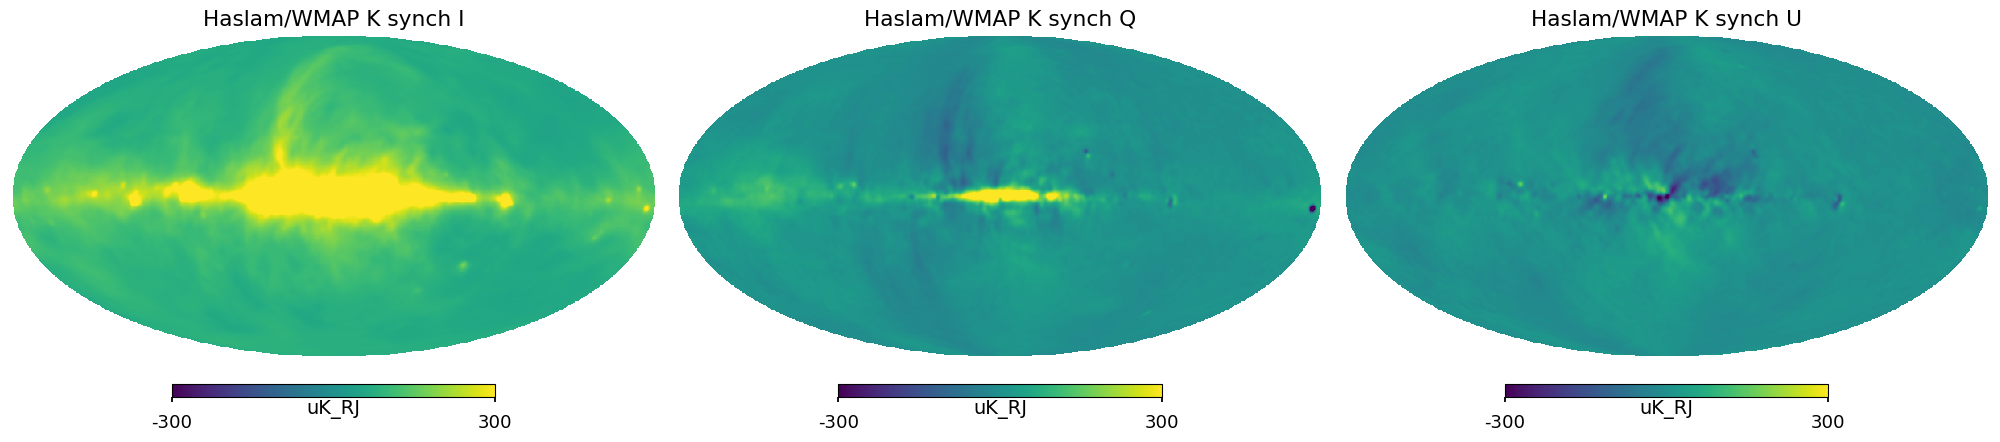

In [21]:
plt.figure(figsize=(20, 5))
for i_pol, pol in components:
    hp.mollview(
        IQU[i_pol],
        title="Haslam/WMAP K synch " + pol,
        sub=131 + i_pol,
        unit=IQU.unit,
        min=-300,
        max=300,
    )

In [22]:
if not os.path.exists(datadir / "synch_hybrid.fits"):
    hp.write_map(datadir / "synch_hybrid.fits", IQU)

In [23]:
import numpy as np
import healpy as hp


def map_to_log_pol_tens(m):
    P = np.sqrt(m[1] ** 2 + m[2] ** 2)
    log_pol_tens = np.empty_like(m)
    log_pol_tens[0] = np.log(m[0] ** 2 - P**2) / 2.0
    log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0
    return log_pol_tens


def log_pol_tens_to_map(log_pol_tens):
    P = np.sqrt(log_pol_tens[1] ** 2 + log_pol_tens[2] ** 2)
    m = np.empty_like(log_pol_tens)
    exp_i = np.exp(log_pol_tens[0])
    m[0] = exp_i * np.cosh(P)
    m[1:] = log_pol_tens[1:] / P * exp_i * np.sinh(P)
    return m


def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

In [24]:
iqu = map_to_log_pol_tens(IQU.value)

/tmp/ipykernel_53785/1699011499.py:8: RuntimeWarning: invalid value encountered in log
  log_pol_tens[0] = np.log(m[0] ** 2 - P**2) / 2.0
/tmp/ipykernel_53785/1699011499.py:9: RuntimeWarning: invalid value encountered in log
  log_pol_tens[1:] = m[1:] / P * np.log((m[0] + P) / (m[0] - P)) / 2.0


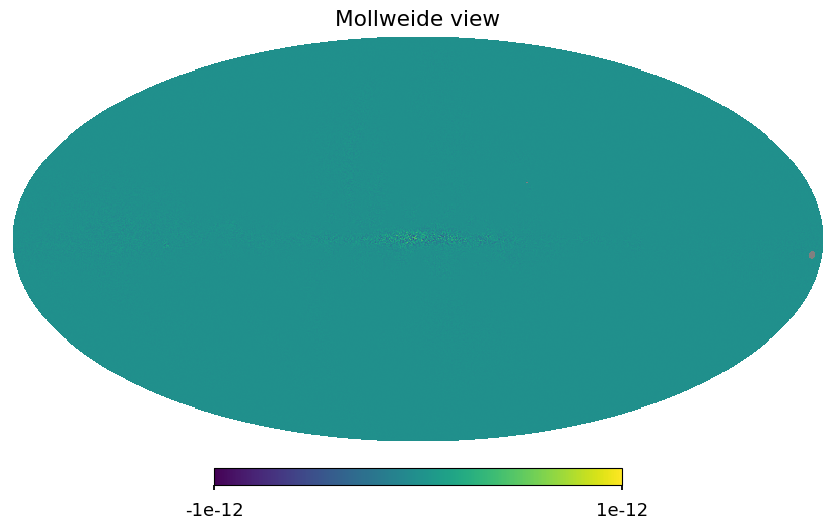

In [25]:
m_back = log_pol_tens_to_map(iqu)
hp.mollview((IQU.value - m_back)[1], min=-1e-12, max=1e-12)
del m_back

In [26]:
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)
for i in range(3):
    iqu[i, np.isnan(iqu[i])] = np.nanmedian(iqu[i])
assert np.isnan(iqu).sum() == 0
print(
    f"{np.isnan(iqu[0]).sum()  } pixels out of { iqu[0].size} are NaNs in Log Pol Tens maps "
)

527 pixels out of 3145728 are NaNs in Log Pol Tens maps 
0 pixels out of 3145728 are NaNs in Log Pol Tens maps 


In [27]:
if not os.path.exists(datadir / "synch_logpoltens.fits"):
    hp.write_map(datadir / "synch_logpoltens.fits", iqu)

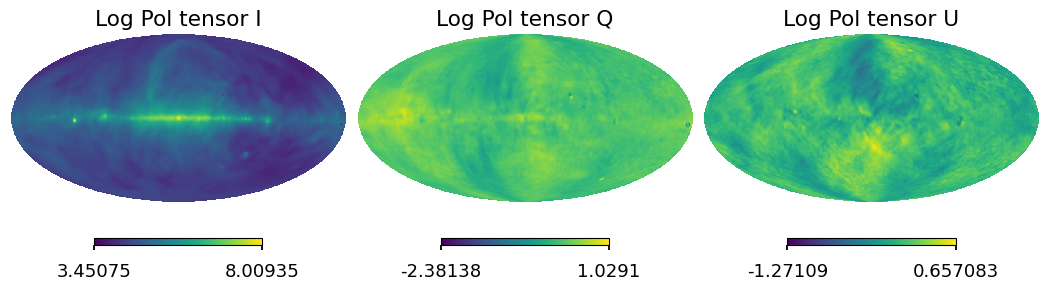

In [28]:
for i_pol, pol in components:
    hp.mollview(iqu[i_pol], title="Log Pol tensor " + pol, sub=131 + i_pol)

In [29]:
from scipy.optimize import curve_fit

In [30]:
def model(ell, A, gamma):
    out = A * ell**gamma
    return out

In [31]:
def run_anafast(m, lmax):
    clanaf = hp.anafast(m, lmax=lmax)
    cl = {}
    cl["TT"] = clanaf[0]
    cl["EE"] = clanaf[1]
    cl["BB"] = clanaf[2]
    cl["TE"] = clanaf[3]
    ell = np.arange(lmax + 1, dtype=float)

    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl


def run_namaster(m, mask, lmax, nlbins):
    """Compute C_ell with NaMaster
    Parameters
    ----------
    m : numpy array
        T only or TQU HEALPix map
    mask : numpy array
        mask, 1D, 0 for masked pixels,
        needs to have same Nside of the input map
    lmax : int
        maximum ell of the spherical harmonics transform
    Returns
    -------
    ell : numpy array
        array of ell from 0 to lmax (length lmax+1)
    cl_norm : numpy array
        ell (ell+1)/2pi factor to turn C_ell into D_ell
        first element is set to 1
    cl : dict of numpy arrays
        dictionary of numpy arrays with all components
        of the spectra, for now only II, EE, BB, no
        cross-spectra
    """

    nside = hp.npix2nside(len(mask))
    # b = nmt.NmtBin.from_nside_linear(nside, 16)
    # leff = b.get_effective_ells()
    binning = nmt.NmtBin(nside=nside, nlb=nlbins, lmax=lmax, is_Dell=False)

    cl = {}

    if len(m) == 3:
        f_0 = nmt.NmtField(mask, [m[0]])
        f_2 = nmt.NmtField(
            mask, m[1:].copy(), purify_b=True
        )  # NaMaster masks the map in-place
        cl_namaster = nmt.compute_full_master(f_2, f_2, binning)
        cl["EE"] = np.concatenate([[0, 0], cl_namaster[0]])
        cl["BB"] = np.concatenate([[0, 0], cl_namaster[3]])
        cl_namaster = nmt.compute_full_master(f_0, f_2, binning)
        cl["TE"] = np.concatenate([[0, 0], cl_namaster[0]])
    elif m.ndim == 1:
        m = m.reshape((1, -1))
        f_0 = nmt.NmtField(mask, [m[0]])

    cl_namaster_I = nmt.compute_full_master(f_0, f_0, binning)

    cl["TT"] = np.concatenate([[0, 0], cl_namaster_I[0]])
    ell = np.concatenate([[0, 1], binning.get_effective_ells()])
    cl_norm = ell * (ell + 1) / np.pi / 2
    cl_norm[0] = 1
    return ell, cl_norm, cl

In [32]:
print("run anafast on masked sky  ")
ell, cl_norm, cl = run_anafast(iqu, lmax)

run anafast on masked sky  


## Power law fit 

- We fit in$\ell \in[1-,36]$ a power law for TT spectrum of the logpol tens i map
- we use the spectral index power law also for EE and BB power spectra to avoid unphysical crossings of EE over TT and BB over TT at higher multipoles


/tmp/ipykernel_53785/3875259470.py:2: RuntimeWarning: divide by zero encountered in reciprocal
  out = A * ell**gamma
/tmp/ipykernel_53785/3875259470.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell**gamma


(1e-05, 0.1)

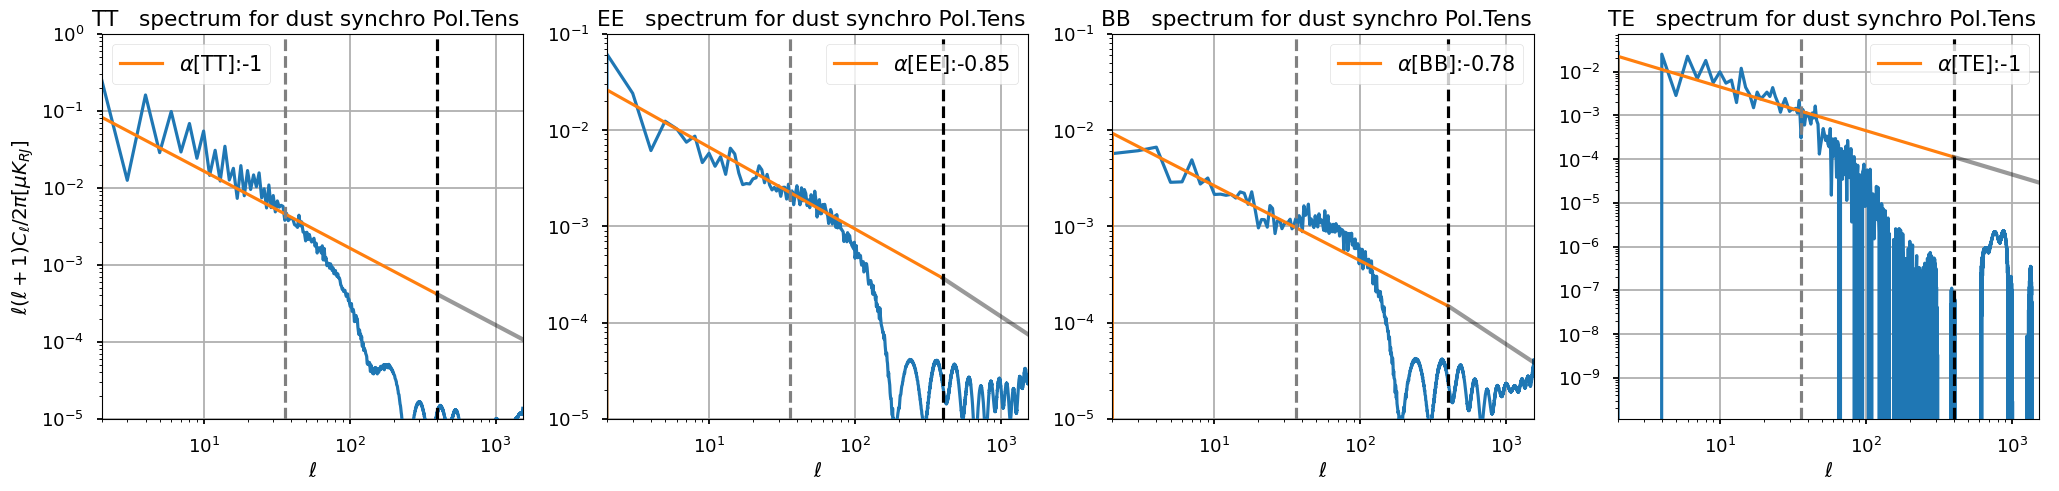

In [33]:
ell_fit_low = {"TT": 10, "EE": 10, "BB": 10, "TE": 10}
ell_fit_high = {"TT": 36, "EE": 36, "BB": 36, "TE": 36}
gamma_fit2 = {"TT": -1, "EE": -0.85, "BB": -0.78, "TE": -1}
A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))
A_fit2 = {}
smallscales = []

ell_pivot = 400
for ii, pol in enumerate(spectra_components):
    plt.subplot(141 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)
    A_fit2[pol] = np.fabs(A_fit[pol]) * ell_fit_high[pol] ** (
        gamma_fit[pol] - gamma_fit2[pol]
    )
    plt.loglog(ell, ell * (ell + 1) / np.pi / 2 * cl[pol])
    scaling = model(ell[:ell_pivot], A_fit2[pol], gamma_fit2[pol])
    scaling[:2] = 0
    plt.plot(ell[:ell_pivot], scaling, label=r"$\alpha$" + f"[{pol}]:{gamma_fit2[pol]}")
    smallscales.append(scaling)

    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
    plt.axvline(ell_pivot, linestyle="--", color="k")
    plt.grid()
    plt.title(f"{pol}   spectrum for dust synchro Pol.Tens  ")

    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)
    plt.legend(fontsize=15)

for ii, pol in enumerate(spectra_components):
    # we change the EE and BB power laws
    xdata = np.arange(ell_fit_high[pol], ell.size)
    ydata = xdata * (xdata + 1) / np.pi / 2 * cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    plt.subplot(141 + ii)
    if pol == "TE":
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TE"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TE"])

        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        A_fit2[pol] = A_fit2[pol] * ell_pivot ** (gamma_fit2[pol] - gamma_fit2["TT"])
        scaling = model(ell[ell_pivot:], A_fit2[pol], gamma_fit2["TT"])
        plt.plot(
            ell[ell_pivot:],
            scaling,
            linewidth=3,
            alpha=0.4,
            color="k",
        )
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

plt.subplot(141)

plt.ylabel("$\ell(\ell+1)C_\ell/2\pi [\mu K_{RJ}]$")
plt.ylim(1e-5, 1e0)
plt.subplot(142)
plt.ylim(1e-5, 1e-1)
plt.subplot(143)
plt.ylim(1e-5, 1e-1)
plt.subplot(143)
plt.ylim(1e-5, 1e-1)

In [34]:
output_nside = 8192
output_lmax = 2*output_nside
lmax = int(1.5 * nside)
ell = np.arange(output_lmax + 1)
cl_norm = ell * (ell + 1) / np.pi / 2
cl_norm[:1] = 1

In [35]:
output_ell = np.arange(output_lmax + 1, dtype=np.double)[len(smallscales[0]):]
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2

In [36]:
for ii, pol in enumerate(spectra_components):
    if pol == "TE":
        scaling = model(output_ell, A_fit2[pol], gamma_fit2["TE"])
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])
    else:
        scaling = model(output_ell, A_fit2[pol], gamma_fit2["TT"])
        smallscales[ii] = np.concatenate([smallscales[ii], scaling])

In [37]:
output_ell = np.arange(output_lmax + 1)
output_cl_norm = output_ell * (output_ell + 1) / np.pi / 2
output_cl_norm[:1] = 1

### Define Modulation maps 
as suggested by Ben Thorne , 
the injected small scales are at different multipoles for intensity and polarization, we consider 2 different modulation maps  
 

#### Modulation for  intensity : 
- smooth `i` map to 5 deg 
- for  the pixels >5  MinMax rescaling from 1.1 to 2 
- elsewhere MinMax rescaling  from  .1 to 1.1   

In [38]:
ismooth = hp.smoothing(iqu[0], fwhm=np.radians(5))

In [39]:
minmax = lambda m, a, b: a + (b - a) * (m - m.min()) / (m.max() - m.min())

modulate_amp = (ismooth) * 1.0
mskmd = ismooth > 5

modulate_amp[mskmd] = minmax(ismooth[mskmd], 1.1, 2)
modulate_amp[~mskmd] = minmax(ismooth[~mskmd], 0.1, 1.1)

In [40]:
ulogpol = hp.ud_grade(map_in=iqu, nside_out=256)
nsidepatches = 8
patches = np.arange(hp.nside2npix(nsidepatches))
nsideA = hp.get_nside(ulogpol)

upatches = hp.ud_grade(patches, nside_out=nsideA)

In [41]:
import time
import pymaster as nmt


def ClEE(mask, mapp):
    map1 = mapp.copy()
    b = nmt.NmtBin.from_nside_linear(hp.get_nside(mask), 25)
    f_2 = nmt.NmtField(mask, map1, purify_b=False)
    cl_22 = nmt.compute_full_master(f_2, f_2, b)
    ell_arr = b.get_effective_ells()
    return (ell_arr, cl_22[0])

In [42]:
small_scales_input_cl = [
    smallscales[ii] * sigmoid(output_ell, ell_fit_high[pol], ell_fit_high[pol] / 10) / output_cl_norm
    for ii, pol in enumerate(spectra_components)
]

In [43]:
output_cl_norm

array([1.00000000e+00, 3.18309886e-01, 9.54929659e-01, ...,
       4.27150073e+07, 4.27202221e+07, 4.27254373e+07])

In [44]:
def set_units(filename, unit):
    f = fits.open(filename)
    for i in range(len(f[1].columns)):
        f[1].header[f"TUNIT{i+1}"] = unit
    f.writeto(filename, overwrite=True)

In [45]:
hp.write_cl(
    proddir / f"synch_small_scales_logpoltens_cl_lmax{output_lmax}.fits.gz",
    small_scales_input_cl,
    dtype=np.complex128,
    overwrite=True,
)
set_units(proddir / f"synch_small_scales_logpoltens_cl_lmax{output_lmax}.fits.gz", "uK_RJ**2")

In [46]:
try:
    ampl_smooth_minmax = hp.read_map(datadir / "pysm2_mod_synch_nside8.fits")
except FileNotFoundError:
    amplitude = np.zeros_like(patches, dtype=float)
    for i in patches:
        start = time.perf_counter()

        maskpixs = upatches == i
        patch = maskpixs * ulogpol
        fsky = maskpixs.sum() / maskpixs.size
        ell_, clp = ClEE(maskpixs, ulogpol[1:])
        amplitude[i] = np.sqrt(abs(clp[2] / small_scales_input_cl[1][np.int_(ell_[2])]))
        end = time.perf_counter()
        if i % 100 == 0:
            print(i, end - start)

    A = hp.ud_grade(amplitude, nside_out=hp.get_nside(iqu))

    ampl_smooth = hp.smoothing(A, fwhm=np.radians(10), lmax=80)

    ampl_smooth_minmax = minmax(ampl_smooth, a=ampl_smooth.min(), b=2)
    hp.write_map(
        datadir / f"pysm2_mod_synch_nside8.fits", ampl_smooth_minmax, overwrite=True
    )

In [47]:
np.random.seed(777)
# filter large scales
alm_log_pol_tens_fullsky = hp.map2alm(iqu, lmax=lmax, use_pixel_weights=True)
ii_LS_alm = np.empty_like(alm_log_pol_tens_fullsky)

for ii, pol in enumerate(spectra_components[:-1]):

    sig_func = sigmoid(ell, x0=ell_fit_high[pol], width=ell_fit_high[pol] / 10)
    ii_LS_alm[ii] = hp.almxfl(alm_log_pol_tens_fullsky[ii], (1.0 - sig_func) ** 0.2)

In [48]:
for name, each_modulate in [("temperature", modulate_amp), ("polarization", ampl_smooth_minmax)]:
    alm = hp.map2alm(each_modulate, lmax=1.5 * nside, use_pixel_weights=True)
    hp.write_alm(proddir / f"synch_{name}_modulation_alms_lmax{int(1.5*nside):d}.fits.gz",
             alm, overwrite=True, out_dtype=np.float32)
    set_units(proddir / f"synch_{name}_modulation_alms_lmax{int(1.5*nside):d}.fits.gz", "")

In [49]:
hp.write_alm(
    proddir / f"synch_largescale_template_logpoltens_alm_nside{nside}_lmax{lmax:d}_complex64.fits.gz",
    ii_LS_alm,
    lmax=lmax,
    out_dtype=np.complex64,
    overwrite=True,
)
set_units(proddir / f"synch_largescale_template_logpoltens_alm_nside{nside}_lmax{lmax:d}_complex64.fits.gz", "uK_RJ")